In [1]:
# dependencies
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import time
import pickle
import data_utils
import matplotlib.pyplot as plt
import re

[nltk_data] Downloading package stopwords to C:\Users\Tom
[nltk_data]     Lazar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from collections import Counter

sentence_size = 30

def read_sentences(file_path):
    sentences = []

    with open(file_path, 'r') as reader:
        for s in reader:
            sentences.append(s.strip())

    return sentences

def read_all_sentences(file_paths):
    all_sentences = []

    for file_path in file_paths:
        all_sentences += read_sentences(file_path)

    return all_sentences

def iteritems(dic):
    return iter([(key, dic[key]) for key in dic])

stopwords_=set(stopwords.words('english'))

def create_dataset(en_sentences, de_sentences):
    bad_characters = ',." ;:)(][?!|'
    
    en_sentences = [[word.strip(bad_characters).lower() for word in sentence.split()] for sentence in en_sentences]
    de_sentences = [[word.strip(bad_characters).lower() for word in sentence.split()] for sentence in de_sentences]
    
    take_out_stopwords = False
    
    en_vocab_dict = Counter(word for sentence in en_sentences for word in sentence if ((not take_out_stopwords or word not in stopwords_) and word is not ''))
    de_vocab_dict = Counter(word for sentence in de_sentences for word in sentence if ((not take_out_stopwords or word not in stopwords_) and word is not ''))

    en_vocab = list(map(lambda x: x[0], sorted(en_vocab_dict.items(), key = lambda x: -x[1])))
    de_vocab = list(map(lambda x: x[0], sorted(de_vocab_dict.items(), key = lambda x: -x[1])))

    en_vocab = en_vocab[:25000]
    de_vocab = de_vocab[:50000]
    print(de_vocab[:50])

    start_idx = 2
    en_word2idx = dict([(word, idx+start_idx) for idx, word in enumerate(en_vocab)])
    en_word2idx['<ukn>'] = 0
    en_word2idx['<pad>'] = 1

    en_idx2word = dict([(idx, word) for word, idx in iteritems(en_word2idx)])


    start_idx = 4
    de_word2idx = dict([(word, idx+start_idx) for idx, word in enumerate(de_vocab)])
    de_word2idx['<ukn>'] = 0
    de_word2idx['<go>']  = 1
    de_word2idx['<eos>'] = 2
    de_word2idx['<pad>'] = 3

    de_idx2word = dict([(idx, word) for word, idx in iteritems(de_word2idx)])

    x = [[en_word2idx.get(word.strip(bad_characters), 0) for word in sentence if (not take_out_stopwords or word not in stopwords_)] for sentence in en_sentences]
    y = [[de_word2idx.get(word.strip(bad_characters), 0) for word in sentence if (not take_out_stopwords or word not in stopwords_)] for sentence in de_sentences]

    X = []
    Y = []
    for i in range(len(x)):
        n1 = len(x[i])
        n2 = len(y[i])
        n = n1 if n1 < n2 else n2 
        #if abs(n1 - n2) <= 0.3 * n:
        if n1 <= sentence_size and n2 <= sentence_size:
            X.append(x[i])
            Y.append(y[i])

    return X, Y, en_word2idx, en_idx2word, en_vocab, de_word2idx, de_idx2word, de_vocab

def save_dataset(file_path, obj):
    with open(file_path, 'wb') as f:
        pickle.dump(obj, f, -1)

def main():
    en_sentences = read_all_sentences(['./Data/bible.en', './Data/Gita-data.en'])
    de_sentences = read_all_sentences(['./Data/bible.san', './Data/Gita-data.san'])

    save_dataset('./Data/data.pkl', create_dataset(de_sentences, en_sentences))

In [3]:
main()

['and', 'the', 'of', 'to', 'he', 'that', 'in', 'him', 'unto', 'they', 'is', 'i', 'a', 'for', 'them', 'not', 'be', 'his', 'was', 'with', 'shall', 'said', 'which', 'but', 'it', 'ye', 'you', 'all', 'when', 'me', 'god', 'have', 'are', 'as', 'this', 'jesus', 'thou', 'from', 'man', 'by', 'were', 'into', 'my', 'had', 'on', 'then', 'one', 'there', 'come', 'their']


In [4]:
def convert_sanskrit(uni):
    a = bytearray(uni, encoding = "utf-8").decode('unicode-escape')
    return a

In [5]:
# read dataset
def read_dataset(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f,encoding="utf_8")

X, Y, en_word2idx, en_idx2word, en_vocab, de_word2idx, de_idx2word, de_vocab = read_dataset('./Data/data.pkl')

In [6]:
#inspecting data
print('Sentence in Sanskrit - encoded:', X[0])
print('Sentence in English - encoded:', Y[0])
print('Decoded:\n------------------------')

for i in range(len(X[1])):
    print(convert_sanskrit(en_idx2word[X[1][i]]), end = " ")
    
print('\n')

for i in range(len(Y[1])):
    print(de_idx2word[Y[1][i]], end = " ")

Sentence in Sanskrit - encoded: [688, 1181, 506, 6, 1181, 11328, 0]
Sentence in English - encoded: [5, 583, 6, 5, 462, 6, 39, 139, 0, 5, 62, 6, 333, 0, 5, 62, 6, 328, 0]
Decoded:
------------------------
इब्राहीमः पुत्र इस्हाक् तस्य पुत्रो याकूब् तस्य पुत्रो यिहूदास्तस्य भ्रातरश्च। 

abraham begat isaac <ukn> and isaac begat jacob <ukn> and jacob begat judas and his brethren <ukn> 

In [7]:
print(sum([len(sentence) for sentence in X]) / len(X))
print(sum([len(sentence) for sentence in Y]) / len(Y))

11.58403468502933
21.631981637337415


In [8]:
# data processing

# data padding
def data_padding(x, y, length = sentence_size):
    for i in range(len(x)):
        x[i] = x[i] + (length - len(x[i])) * [en_word2idx['<pad>']]
        y[i] = [de_word2idx['<go>']] + y[i] + [de_word2idx['<eos>']] + (length-len(y[i])) * [de_word2idx['<pad>']]

data_padding(X, Y)

# data splitting
X_train,  X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1)

print(len(X), len(Y), len(X_train), len(X_test), len(Y_train), len(Y_test))

del X
del Y

3921 3921 3528 393 3528 393


In [9]:
# build a model

input_seq_len = sentence_size
output_seq_len = input_seq_len + 2
en_vocab_size = len(en_vocab) + 2 # + <pad>, <ukn>
de_vocab_size = len(de_vocab) + 4 # + <pad>, <ukn>, <eos>, <go>

# placeholders
encoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'encoder{}'.format(i)) for i in range(input_seq_len)]
decoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'decoder{}'.format(i)) for i in range(output_seq_len)]

targets = [decoder_inputs[i+1] for i in range(output_seq_len-1)]
# add one more target
targets.append(tf.placeholder(dtype = tf.int32, shape = [None], name = 'last_target'))
target_weights = [tf.placeholder(dtype = tf.float32, shape = [None], name = 'target_w{}'.format(i)) for i in range(output_seq_len)]

# output projection
size = 512
w_t = tf.get_variable('proj_w', [de_vocab_size, size], tf.float32)
b = tf.get_variable('proj_b', [de_vocab_size], tf.float32)
w = tf.transpose(w_t)
output_projection = (w, b)

outputs, states = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
                                            encoder_inputs,
                                            decoder_inputs,
                                            tf.contrib.rnn.BasicLSTMCell(size),
                                            num_encoder_symbols = en_vocab_size,
                                            num_decoder_symbols = de_vocab_size,
                                            embedding_size = 100,
                                            feed_previous = False,
                                            output_projection = output_projection,
                                            dtype = tf.float32)

In [10]:
# define our loss function

# sampled softmax loss - returns: A batch_size 1-D tensor of per-example sampled softmax losses
def sampled_loss(labels, logits):
    return tf.nn.sampled_softmax_loss(
                        weights = w_t,
                        biases = b,
                        labels = tf.reshape(labels, [-1, 1]),
                        inputs = logits,
                        num_sampled = 512,
                        num_classes = de_vocab_size)

# Weighted cross-entropy loss for a sequence of logits
loss = tf.contrib.legacy_seq2seq.sequence_loss(outputs, targets, target_weights, softmax_loss_function = sampled_loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [11]:
# let's define some helper functions

# simple softmax function
def softmax(x):
    n = np.max(x)
    e_x = np.exp(x - n)
    return e_x / e_x.sum()

# feed data into placeholders
def feed_dict(x, y, batch_size = 64):
    feed = {}
    
    idxes = np.random.choice(len(x), size = batch_size, replace = False)
    
    for i in range(input_seq_len):
        feed[encoder_inputs[i].name] = np.array([x[j][i] for j in idxes], dtype = np.int32)
        
    for i in range(output_seq_len):
        feed[decoder_inputs[i].name] = np.array([y[j][i] for j in idxes], dtype = np.int32)
        
    feed[targets[len(targets)-1].name] = np.full(shape = [batch_size], fill_value = de_word2idx['<pad>'], dtype = np.int32)
    
    for i in range(output_seq_len-1):
        batch_weights = np.ones(batch_size, dtype = np.float32)
        target = feed[decoder_inputs[i+1].name]
        for j in range(batch_size):
            if target[j] == de_word2idx['<pad>']:
                batch_weights[j] = 0.0
        feed[target_weights[i].name] = batch_weights
        
    feed[target_weights[output_seq_len-1].name] = np.zeros(batch_size, dtype = np.float32)
    
    return feed

# decode output sequence
def decode_output(output_seq):
    words = []
    for i in range(output_seq_len):
        smax = softmax(output_seq[i])
        idx = np.argmax(smax)
        words.append(de_idx2word[idx])
    return words

In [12]:
# ops for projecting outputs
outputs_proj = [tf.matmul(outputs[i], output_projection[0]) + output_projection[1] for i in range(output_seq_len)]

saver = tf.train.Saver()

# we will use this list to plot losses through steps
losses = []

In [13]:
learning_rate_placeholder = tf.placeholder(tf.float32, shape=[])
default_learning_rate = 0.01
learning_rate = default_learning_rate
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate_placeholder).minimize(loss)

In [14]:
# ops and hyperparameters
learning_rate_thresholds = {
    10000000: default_learning_rate,
    5: 0.008,
    2: 0.005,
    1: 0.001,
    0.05: 0.0008,
    0.01: 0.0001,
    0.001: 0.00001
}
batch_size = 728
steps = 4000

# init op
init = tf.global_variables_initializer()

# forward step
def forward_step(sess, feed):
    output_sequences = sess.run(outputs_proj, feed_dict = feed)
    return output_sequences

# training step
def backward_step(sess, optimizer, feed):
    sess.run(optimizer, feed_dict = feed)

In [24]:
# let's train the model

# save a checkpoint so we can restore the model later 
#tf.trainable_variables())
checkpointsPath = './checkpoints501fix/'
restore = False
starting_step = 0

print('------------------TRAINING------------------')
with tf.Session() as sess:
    sess.run(init)
    if (restore):
        print('Restoring')
        with open(checkpointsPath + 'checkpoint') as f:
            starting_step = int(re.match('model_checkpoint_path: "-([0-9]+)"', list(f)[0]).groups()[0]) + 1
        saver.restore(sess, tf.train.latest_checkpoint(checkpointsPath))
        print('Running from step {}'.format(starting_step))
    else:
        print('Running from scratch: generating random model parameters.')
        learning_rate = default_learning_rate
    
    print("Starting")
    t = time.time()
    for step in range(starting_step, starting_step + steps):
        feed = feed_dict(X_train, Y_train)
        feed[learning_rate_placeholder] = learning_rate
            
        backward_step(sess, optimizer, feed)
        
        if step % 10 == 9 or step == 0:
            loss_value = sess.run(loss, feed_dict = feed)
            print('step: {}, loss: {} learning_rate: {}'.format(step, loss_value, learning_rate))
            losses.append(loss_value)
            
            # training op
            new_learning_rate = learning_rate_thresholds[sorted(filter(lambda x: x > loss_value, list(learning_rate_thresholds.keys())))[0]]
            if new_learning_rate is not learning_rate:
                print('New learning rate')
                learning_rate = new_learning_rate
            
        
        if step % 100 == 99:
            saver.save(sess, checkpointsPath, global_step=step)
            print('Checkpoint is saved')
            
    print('Training time for {} steps: {}s'.format(steps, time.time() - t))

------------------TRAINING------------------
Restoring
INFO:tensorflow:Restoring parameters from ./checkpoints501/-399
Running from step 400
Starting
step: 409, loss: 2.682797431945801 learning_rate: 0.005
New learning rate
step: 419, loss: 2.70666241645813 learning_rate: 0.008
step: 429, loss: 2.285507917404175 learning_rate: 0.008
step: 439, loss: 2.7030978202819824 learning_rate: 0.008
step: 449, loss: 2.633201837539673 learning_rate: 0.008
step: 459, loss: 2.433051109313965 learning_rate: 0.008
step: 469, loss: 2.5908358097076416 learning_rate: 0.008
step: 479, loss: 2.3824462890625 learning_rate: 0.008
step: 489, loss: 2.42240571975708 learning_rate: 0.008
step: 499, loss: 2.3938679695129395 learning_rate: 0.008
Checkpoint is saved
step: 509, loss: 2.3565049171447754 learning_rate: 0.008
step: 519, loss: 2.2031619548797607 learning_rate: 0.008
step: 529, loss: 2.0262017250061035 learning_rate: 0.008
step: 539, loss: 1.7325880527496338 learning_rate: 0.008
New learning rate
step: 5

step: 1729, loss: 0.06684702634811401 learning_rate: 0.001
step: 1739, loss: 0.06981673836708069 learning_rate: 0.001
step: 1749, loss: 0.1042078360915184 learning_rate: 0.001
step: 1759, loss: 0.040401071310043335 learning_rate: 0.001
New learning rate
step: 1769, loss: 0.04845914989709854 learning_rate: 0.0008
step: 1779, loss: 0.0453171506524086 learning_rate: 0.0008
step: 1789, loss: 0.03857841715216637 learning_rate: 0.0008
step: 1799, loss: 0.05254897475242615 learning_rate: 0.0008
New learning rate
Checkpoint is saved
step: 1809, loss: 0.08554959297180176 learning_rate: 0.001
step: 1819, loss: 0.04202941805124283 learning_rate: 0.001
New learning rate
step: 1829, loss: 0.018220778554677963 learning_rate: 0.0008
step: 1839, loss: 0.025423910468816757 learning_rate: 0.0008
step: 1849, loss: 0.06032416224479675 learning_rate: 0.0008
New learning rate
step: 1859, loss: 0.06285335123538971 learning_rate: 0.001
step: 1869, loss: 0.05171450600028038 learning_rate: 0.001
step: 1879, los

KeyboardInterrupt: 

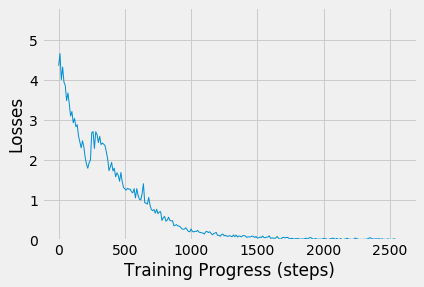

In [38]:
# plot losses
view = losses[805:]

with plt.style.context('fivethirtyeight'):
    stepinterval = 10
    plt.plot(list(range(0, len(view) * stepinterval, stepinterval)), view, linewidth = 1)
    plt.xlabel('Training Progress (steps)'.format(starting_step))
    plt.ylabel('Losses')
    plt.ylim((-0.01, max(view) + (0.25 * max(view))))

plt.show()

In [49]:
# let's test the model

with tf.Graph().as_default():
    
    # placeholders
    encoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'encoder{}'.format(i)) for i in range(input_seq_len)]
    decoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'decoder{}'.format(i)) for i in range(output_seq_len)]

    # output projection
    size = 512
    w_t = tf.get_variable('proj_w', [de_vocab_size, size], tf.float32)
    b = tf.get_variable('proj_b', [de_vocab_size], tf.float32)
    w = tf.transpose(w_t)
    output_projection = (w, b)
    
    # change the model so that output at time t can be fed as input at time t+1
    outputs, states = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
                                                encoder_inputs,
                                                decoder_inputs,
                                                tf.contrib.rnn.BasicLSTMCell(size),
                                                num_encoder_symbols = en_vocab_size,
                                                num_decoder_symbols = de_vocab_size,
                                                embedding_size = 100,
                                                feed_previous = True, # <-----this is changed----->
                                                output_projection = output_projection,
                                                dtype = tf.float32)
    
    # ops for projecting outputs
    outputs_proj = [tf.matmul(outputs[i], output_projection[0]) + output_projection[1] for i in range(output_seq_len)]

    #let's translate these sentences     
#     en_sentences = ["\u0907\u092c\u094d\u0930\u093e\u0939\u0940\u092e\u0903 \u0938\u0928\u094d\u0924\u093e\u0928\u094b \u0926\u093e\u092f\u0942\u0926\u094d \u0924\u0938\u094d\u092f ",\
#                     '\u0938\u0928\u094d\u0924\u093e\u0928\u094b \u092f\u0940\u0936\u0941\u0916\u094d\u0930\u0940\u0937\u094d\u091f\u0938\u094d\u0924\u0938\u094d\u092f']
#     en_sentences_encoded = [[en_word2idx.get(word, 0) for word in en_sentence.split()] for en_sentence in en_sentences]
    en_sentences_encoded = X_test[10:20]
    print(len(X_test))
    de_sentences_encoded = Y_test[10:20]
        
    additional_en_sentences = ['\\u0924\\u0924\\u0903 <ukn> \\u092a\\u0930\\u0902 \\u092a\\u0941\\u0928\\u0930\\u0928\\u094d\\u092f\\u094b \\u091c\\u0928\\u094b \\u0928\\u093f\\u0936\\u094d\\u091a\\u093f\\u0924\\u094d\\u092f \\u092c\\u092d\\u093e\\u0937\\u0947']
    additional_en_sentences = [sentence + ' '.join(['<pad>'] * (sentence_size - len(sentence.split()))) for sentence in additional_en_sentences]    
    en_sentences_encoded += [[en_word2idx.get(word, 0) for word in en_sentence.split()] for en_sentence in additional_en_sentences]
    additional_de_sentences = ['and about the space of one hour after another confidently affirmed']
    additional_de_sentences = [sentence + ' '.join(['<pad>'] * (sentence_size - len(sentence.split()))) for sentence in additional_de_sentences]
    de_sentences_encoded += [[de_word2idx.get(word, 0) for word in de_sentence.split()] for de_sentence in additional_de_sentences]
    
    # padding to fit encoder input
    for i in range(len(en_sentences_encoded)):
        en_sentences_encoded[i] += (15 - len(en_sentences_encoded[i])) * [en_word2idx['<pad>']]
    
    # restore all variables - use the last checkpoint saved
    saver = tf.train.Saver()
    path = tf.train.latest_checkpoint(checkpointsPath)
    
    with tf.Session() as sess:
        # restore
        saver.restore(sess, path)
        
        # feed data into placeholders
        feed = {}
        for i in range(input_seq_len):
            feed[encoder_inputs[i].name] = np.array([en_sentences_encoded[j][i] for j in range(len(en_sentences_encoded))], dtype = np.int32)
            
        feed[decoder_inputs[0].name] = np.array([de_word2idx['<go>']] * len(en_sentences_encoded), dtype = np.int32)
        
        # translate
        output_sequences = sess.run(outputs_proj, feed_dict = feed)
        
        # decode seq.
        for i in range(len(en_sentences_encoded)):
            print('{}.\n--------------------------------'.format(i+1))
            ouput_seq = [output_sequences[j][i] for j in range(output_seq_len)]
            #decode output sequence
            words = decode_output(ouput_seq)
        
            print(" ". join([convert_sanskrit(en_idx2word[word]) for word in en_sentences_encoded[i]]))
            print(" ". join([(en_idx2word[word]) for word in en_sentences_encoded[i]]))
            print('Translation: ', end = " ")
            for j in range(len(words)):
                if words[j] not in ['<eos>', '<pad>', '<go>']:
                    print((words[j]), end = " ")
            print()
            print('   Expected: ', end = " ")
            for j in range(len(de_sentences_encoded[i])):
                if de_idx2word[de_sentences_encoded[i][j]] not in ['<eos>', '<pad>', '<go>']:
                    print((de_idx2word[de_sentences_encoded[i][j]]), end = " ")
            
            print('\n--------------------------------')

393
INFO:tensorflow:Restoring parameters from ./checkpoints501/-2699


IndexError: list index out of range

# This model can be improved by using more training steps, better dataset or even with better selection of hyperparameters 

In [42]:
print(len(Y_train))

3528


In [46]:
for s in [' '.join([de_idx2word[word] for word in sentence]) for sentence in Y_test[:10]]:
    print(s)

<go> a new commandment i give unto you <ukn> that ye love one another <ukn> as i have loved you <ukn> that ye also love one another <ukn> <eos> <pad> <pad> <pad>
<go> and he said unto them <ukn> full well ye reject the commandment of god <ukn> that ye may keep your own tradition <ukn> <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<go> and all the people that came together to that sight <ukn> beholding the things which were done <ukn> smote their breasts <ukn> and returned <ukn> <eos> <pad> <pad> <pad> <pad> <pad>
<go> and how hear we every man in our own tongue <ukn> wherein we were born <ukn> <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<go> howbeit jesus spake of his death <ukn> but they thought that he had spoken of taking of rest in sleep <ukn> <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
<go> and the serpent cast out of his mouth water as a flood after the woman <ukn> that he might cause her to be carried away of the fl